In [198]:
# data wrangling
import re # regular expressions!

# math and data utilities
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [16, 10]



In [199]:
train_df = pd.read_csv('data/train.csv', index_col='PassengerId')
test_df = pd.read_csv('data/test.csv', index_col='PassengerId')

train_df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Lets combine the two dataframes so that we can preprocess all of the data at once.

We will first pop the 'Survived' column from the training data and save it for later. We also want to save indexes of the training/testing dataframes so that we can split them apart again.

In [200]:
survival = train_df.pop('Survived')
train_idx, test_idx = train_df.index, test_df.index

df = pd.concat([train_df, test_df])

# clear memory, now that we don't need these two df's:
del train_df, test_df

df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 112.5+ KB


### Feature Engineering

From the data, we can tell if a person traveled alone, or with family. We can tell how many people, if any they travelled with. Let's add these features to our dataframe.

In [202]:
df['FamilySize'] = 1 + df.SibSp + df.Parch
df['Alone'] = df.FamilySize.apply(lambda x: 1 if x==1 else 0)

Mr        176
Miss       50
Mrs        27
Master      8
Ms          1
Dr          1
Name: Title, dtype: int64

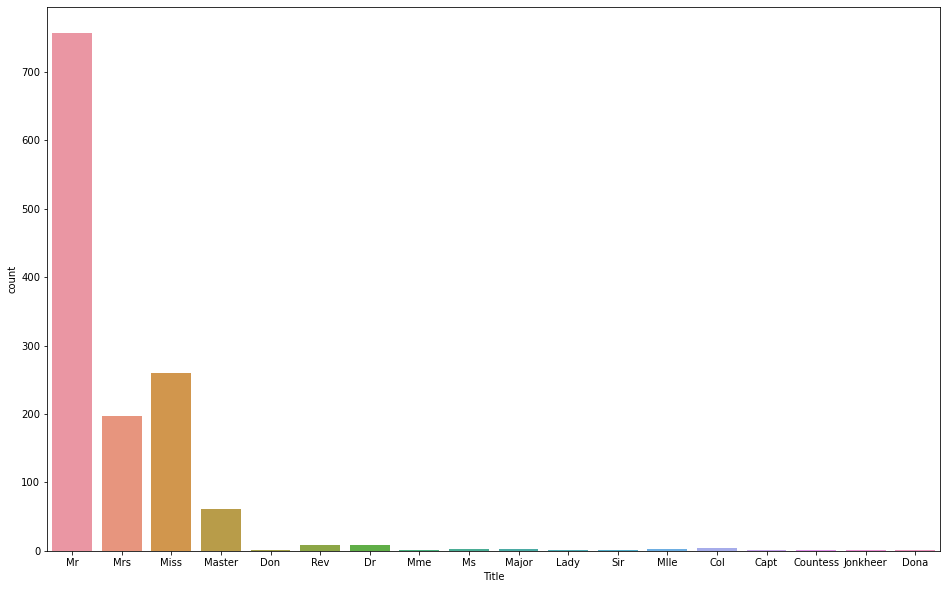

In [203]:
# extract titles:
# The regular expression ([A-Za-z]+) searches for and returns any groups of letters of 
# upper or lower case. The '+' indicates to return any group that occurs 1 or more times
df['Title'] = df.Name.str.extract(r'([A-Za-z]+)\.')

sns.countplot(df.Title)

# let's also check the distribution of missing ages:
df.Title[df.Age.isnull()].value_counts()

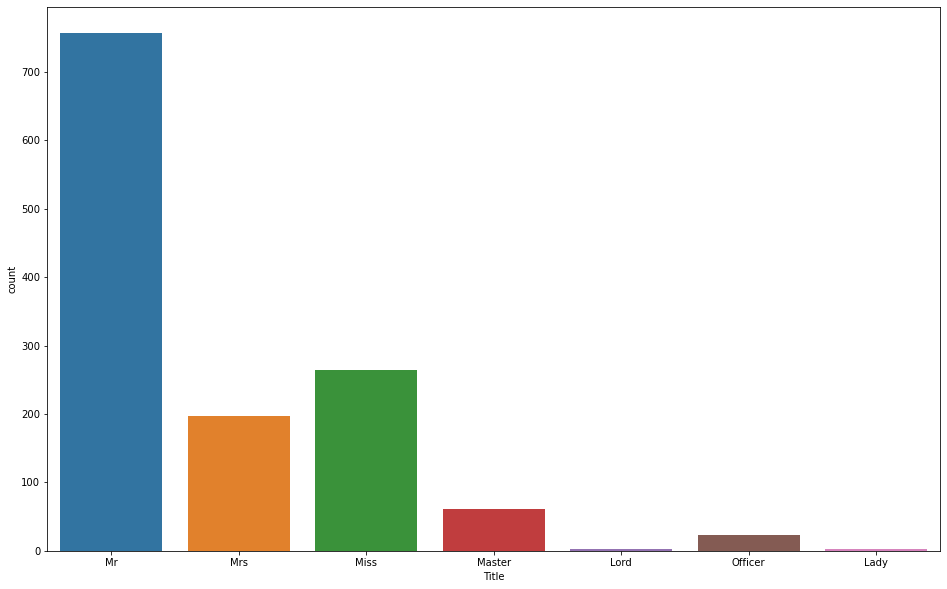

In [204]:
# Many of these names mean similar things, so let's simplify.

title_dict = {
    'Mrs': 'Mrs', 'Lady': 'Lady', 'Countess': 'Lady',
    'Jonkheer': 'Lord', 'Col': 'Officer', 'Rev': 'Officer',
    'Miss': 'Miss', 'Mlle': 'Miss', 'Mme': 'Miss', 'Ms': 'Miss', 'Dona': 'Lady',
    'Mr': 'Mr', 'Dr': 'Officer', 'Major': 'Officer', 'Capt': 'Officer', 'Sir': 'Lord', 'Don': 'Lord', 'Master': 'Master'
}

df.Title = df.Title.map(title_dict)
sns.countplot(df.Title)

In [205]:
df.Title.value_counts()

Mr         757
Miss       265
Mrs        197
Master      61
Officer     23
Lady         3
Lord         3
Name: Title, dtype: int64

There may be some correlation between title and age, allowing us to fill in missing age data.

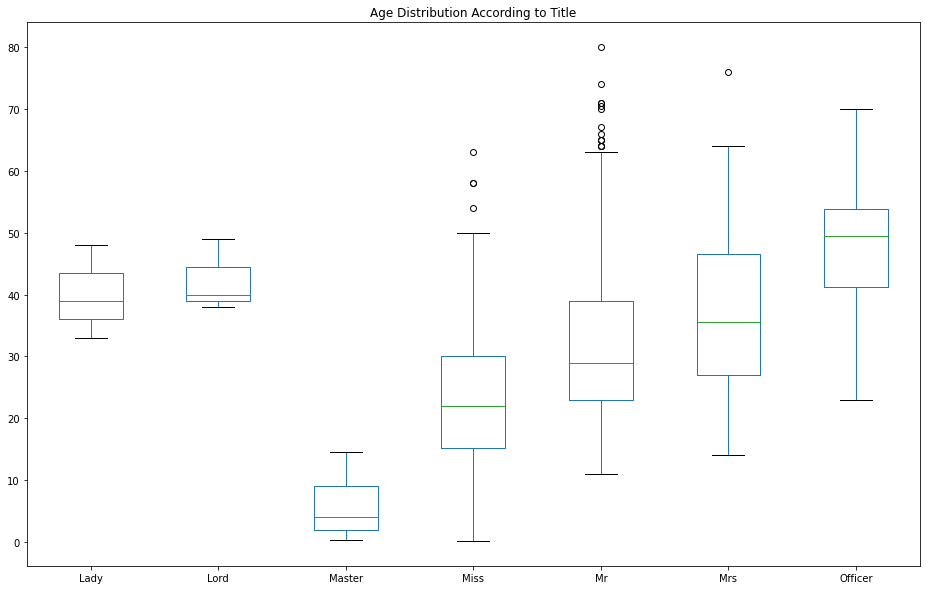

In [206]:
age_title = df[['Title', 'Age']].pivot(columns='Title', values='Age')
age_title.plot(kind='box', title='Age Distribution According to Title')

So, perhaps there is some correlation between age and title. We can use this to guess missing age data. Let's fill that data in. 

In [207]:
# Here is a passenger whose age information is missing:
df.loc[1305]

Pclass                         3
Name          Spector, Mr. Woolf
Sex                         male
Age                          NaN
SibSp                          0
Parch                          0
Ticket                 A.5. 3236
Fare                        8.05
Cabin                        NaN
Embarked                       S
FamilySize                     1
Alone                          1
Title                         Mr
Name: 1305, dtype: object

In [208]:
# Step 1. for each title, get all rows containing this title where age is null, and the column 'Age'.
# Step 2. From the age column, take the average of all the cells that correspond with current
# title. 

for title in df.Title.unique():
    # get all cells containing this title, with age not null
    df.loc[((df.Age.isnull())&(df.Title==title)), 'Age'] = df.Age[df.Title == title].mean() 
    


In [210]:
# Let's see if age was succssfully filled in:
df.loc[1305]

Pclass                         3
Name          Spector, Mr. Woolf
Sex                         male
Age                      32.2522
SibSp                          0
Parch                          0
Ticket                 A.5. 3236
Fare                        8.05
Cabin                        NaN
Embarked                       S
FamilySize                     1
Alone                          1
Title                         Mr
Name: 1305, dtype: object

Sure enought, we have filled in the missing age data with the average age of all other passengers using the title "Mr".

We can repeat the process to determine whether there is a relationship between cabin fare